# Adjusting Size for Classification of Citrus Leaves
See `citrus_leaves.ipynb` for main file.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.io import read_image # use PyTorch to read images
import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [2]:
IMG_DIR = "./data_citrus_leaves/"
TRAIN_PROPORTION = 0.8
BATCH_SIZE = 32
NUM_EPOCHS = 40
IMAGE_SIZE = (256, 256)
LR = 0.001
RESNET_MEAN = [0.485, 0.456, 0.406]
RESNET_STD = [0.229, 0.224, 0.225]

In [3]:
# simple encoder to convert `string` to `int`
encoder = {
    "healthy" : 0,
    "black_spot" : 1,
    "canker" : 2,
    "greening" : 3,
    "healthy" : 4,
    "melanose" : 5
}

decoder = {
    0 : "healthy",
    1 : "black_spot",
    2 : "canker",
    3 : "greening",
    4 : "healthy",
    5 : "melanose"
}

# class label is name of sub directory, images are in sub directory
class CitrusLeavesDataset(Dataset):
    def __init__(self, img_dir, transform = None, target_transform = None, length = None):
        # define main directory of images and transformations
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        # store paths and labels in DataFrame
        data = { "image_path" : [], "label" : [] }
        for sub_dir in os.listdir(img_dir):
            for file in os.listdir(os.path.join(img_dir, sub_dir)):
                data['image_path'].append(os.path.join(img_dir, sub_dir, file))
                data['label'].append(sub_dir)

        # store in annotations
        self.annotations = pd.DataFrame(data).sample(frac = 1).reset_index(drop = True)

        # if length is specified, only use that many samples
        if length is not None:
            if length > len(self.annotations) or length < 1:
                raise ValueError("Length must be between 1 and " + str(len(self.annotations)))
            self.annotations = self.annotations[:length]

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # get image path and label
        image = read_image(self.annotations.iloc[idx, 0]).float()
        label = encoder[self.annotations.iloc[idx, 1]]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [4]:
def create_model(base_model, device = None, learning_rate = LR):
    # load model
    feature_extractor = nn.Sequential(*list(base_model.children())[:-1])

    # create model
    model = nn.Sequential(
        feature_extractor,
        nn.Flatten(),
        nn.Linear(2048, 6)
    )
    
    if device is not None:
        model = model.to(device)

    # define loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    return model, criterion, optimizer

def train_model(model, loader, optimizer, criterion, device = None, epochs = NUM_EPOCHS, stats = False):
    # train model
    model.train()
    losses = []
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(loader):
            if device is not None:
                images = images.to(device)
                labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

            if stats:
                if i % 10 == 0:
                    print("[{}, {}] Loss: {}".format(epoch, i, loss.item()))

    return losses

def test_model(model, loader, device = None):
    # test model
    model.eval()
    predict = torch.tensor([], dtype = torch.long)
    actual = torch.tensor([], dtype = torch.long)

    if device is not None:
        predict = predict.to(device)
        actual = actual.to(device)

    with torch.no_grad():
        for images, labels in loader:
            if device is not None:
                images = images.to(device)
                labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predict = torch.cat((predict, predicted))
            actual = torch.cat((actual, labels))

    return predict, actual

def average_auc(predict, actual, num_classes = 6):
    # calculate average AUC
    scores = []
    for i in range(num_classes):
        fpr, tpr, _ = metrics.roc_curve(actual == i, predict == i)
        scores.append(metrics.auc(fpr, tpr))

    return np.mean(scores)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
resnet50 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained = True)

Using cache found in C:\Users\fongc/.cache\torch\hub\pytorch_vision_v0.6.0
c:\Users\fongc\anaconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\fongc\anaconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# iterate through sizes
d = {}
for length in range(50, 650, 50):
    d[length] = {}

    # load data
    data = CitrusLeavesDataset(
        img_dir = IMG_DIR,
        transform = transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.Normalize(mean = RESNET_MEAN, std = RESNET_STD)
        ]),
        length = length
    )

    # perform stratified k-fold cross validation instead of random_split
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    for i, (train_index, test_index) in enumerate(
        skf.split(data.annotations['image_path'],
        data.annotations['label'])
    ):
        dict_key = "fold_{}".format(i)
        d[length][dict_key] = {}
    
        # create test and train with k-fold (see main file for random_split)
        train = Subset(data, train_index)
        test = Subset(data, test_index)
        

        train_loader = DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
        test_loader = DataLoader(test, batch_size = BATCH_SIZE, shuffle = True)

        # create model
        model, criterion, optimizer = create_model(resnet50, device = device)

        # train model
        losses = train_model(model, train_loader, optimizer, criterion, device = device)
        d[length]['losses'] = losses

        # test model
        predict, actual = test_model(model, test_loader, device = device)
        d[length][dict_key]['predict'] = predict
        d[length][dict_key]['actual'] = actual

        print("[Length {}, Fold {}] Accuracy: {}".format(
            length, i,
            metrics.accuracy_score(actual.cpu().numpy(), predict.cpu().numpy())
        ))

c:\Users\fongc\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[Length 50, Fold 0] Accuracy: 0.9
[Length 50, Fold 1] Accuracy: 0.4
[Length 50, Fold 2] Accuracy: 0.7
[Length 50, Fold 3] Accuracy: 0.6
[Length 50, Fold 4] Accuracy: 0.8


c:\Users\fongc\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[Length 100, Fold 0] Accuracy: 0.75
[Length 100, Fold 1] Accuracy: 0.95
[Length 100, Fold 2] Accuracy: 0.95
[Length 100, Fold 3] Accuracy: 0.7
[Length 100, Fold 4] Accuracy: 0.95


c:\Users\fongc\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[Length 150, Fold 0] Accuracy: 0.8666666666666667
[Length 150, Fold 1] Accuracy: 0.5333333333333333
[Length 150, Fold 2] Accuracy: 0.9666666666666667
[Length 150, Fold 3] Accuracy: 1.0
[Length 150, Fold 4] Accuracy: 1.0
[Length 200, Fold 0] Accuracy: 0.875
[Length 200, Fold 1] Accuracy: 1.0
[Length 200, Fold 2] Accuracy: 1.0
[Length 200, Fold 3] Accuracy: 0.975
[Length 200, Fold 4] Accuracy: 0.8


c:\Users\fongc\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[Length 250, Fold 0] Accuracy: 0.94
[Length 250, Fold 1] Accuracy: 0.8
[Length 250, Fold 2] Accuracy: 0.72
[Length 250, Fold 3] Accuracy: 1.0
[Length 250, Fold 4] Accuracy: 0.94
[Length 300, Fold 0] Accuracy: 0.9166666666666666
[Length 300, Fold 1] Accuracy: 0.5
[Length 300, Fold 2] Accuracy: 1.0
[Length 300, Fold 3] Accuracy: 0.9833333333333333
[Length 300, Fold 4] Accuracy: 1.0


c:\Users\fongc\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[Length 350, Fold 0] Accuracy: 0.9571428571428572
[Length 350, Fold 1] Accuracy: 0.9714285714285714
[Length 350, Fold 2] Accuracy: 1.0
[Length 350, Fold 3] Accuracy: 1.0
[Length 350, Fold 4] Accuracy: 1.0
[Length 400, Fold 0] Accuracy: 0.975
[Length 400, Fold 1] Accuracy: 1.0
[Length 400, Fold 2] Accuracy: 1.0
[Length 400, Fold 3] Accuracy: 1.0
[Length 400, Fold 4] Accuracy: 0.8
[Length 450, Fold 0] Accuracy: 0.8777777777777778
[Length 450, Fold 1] Accuracy: 0.9555555555555556
[Length 450, Fold 2] Accuracy: 1.0
[Length 450, Fold 3] Accuracy: 0.9888888888888889
[Length 450, Fold 4] Accuracy: 1.0
[Length 500, Fold 0] Accuracy: 1.0
[Length 500, Fold 1] Accuracy: 1.0
[Length 500, Fold 2] Accuracy: 1.0


In [14]:
accuracies = []
for key in d:
    accuracies.append(metrics.accuracy_score(
        d[key]['actual'].cpu().numpy(),
        d[key]['predict'].cpu().numpy()
    ))

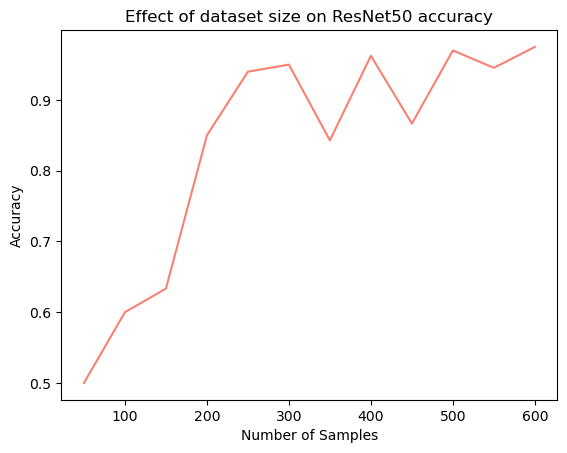

In [15]:
plt.plot(d.keys(), accuracies, c = "salmon")
plt.title("Effect of dataset size on ResNet50 accuracy")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy")
plt.show()